1. After you performed a pre-processing (data cleaning, feature normalization and/or selection, …) on them, apply one machine learning technique of your choice to the pre-processed data to solve your research question.
2. If necessary, perform hyperparameters tuning.
3. Once you obtain you best model, determine the most important factors that
contributed to your results (explainability).

#### Approach

I am choosing to address my 2nd research question "Can we predict the gender of similarly sick patients based on the different burdening of the feet when walking (regarding sensor values under the feet)?". Taking my notes from task one as a reference: For answering my own questions, I propose to enhance the data from the demographics dataset with the averages and median of each of the signal features of the respective patients. Additionally, I'd like to add the minimal and maximal values as well as a min-max range (max-min) as I think these provide some insight in the extreme values or peaks and a summary measure of the overall variation or spread in the burdening of the feet. Overall, these four features should nicely display all relevant information in a overseeable way. As it is not completely clear to me what the numbering of the signal files means, I will only use _01 files but might run do a separate run with all to see if it makes a difference.

In [800]:
import pandas as pd

# Read imputed file from task 1 into a pandas dataframe using tabs as separator
df = pd.read_csv('../task_one/imputed_data_knn.csv', sep=',')
#df = pd.read_csv('../task_one/imputed_data_mean.csv', sep=',')


#### Pre-processing of the base dataset:  
We start by doing the mapping of the signal files onto the correct ID. Then we read out the signal file and calculate: 
- mean
- median
- min
- max
- min-max range

using the corresponding dataframe. These columns are appended to the original df.

In [801]:
# Getting the file mapping from task one in case we want to move to using all files
import os

directory = '../dataset/'

# Get a list of all files in the directory
files = os.listdir(directory)
connected_files = {}

for file in files:
    if not 'txt' in file:
        continue
    data_id = file.split('_')[0]
    connected_file = []

    # Map connected files to each other
    counter = 1
    while True:
        formatted_counter = "{:02d}".format(counter)
        built_file = f"{data_id}_{formatted_counter}.txt"
        if built_file in files:
            connected_file.append(built_file)
        else:
            connected_files[data_id] = connected_file
            break

        counter += 1

print(connected_files)

{'GaPt15': ['GaPt15_01.txt', 'GaPt15_02.txt'], 'JuPt03': ['JuPt03_01.txt', 'JuPt03_02.txt', 'JuPt03_03.txt', 'JuPt03_04.txt', 'JuPt03_05.txt', 'JuPt03_06.txt', 'JuPt03_07.txt'], 'JuPt10': ['JuPt10_01.txt', 'JuPt10_02.txt', 'JuPt10_03.txt', 'JuPt10_04.txt', 'JuPt10_05.txt', 'JuPt10_06.txt', 'JuPt10_07.txt'], 'GaPt31': ['GaPt31_01.txt', 'GaPt31_02.txt'], 'GaPt32': ['GaPt32_01.txt', 'GaPt32_02.txt'], 'JuPt01': ['JuPt01_01.txt', 'JuPt01_02.txt', 'JuPt01_03.txt', 'JuPt01_04.txt', 'JuPt01_05.txt', 'JuPt01_06.txt'], 'SiPt08': ['SiPt08_01.txt'], 'JuPt28': ['JuPt28_01.txt', 'JuPt28_02.txt', 'JuPt28_03.txt', 'JuPt28_04.txt', 'JuPt28_05.txt', 'JuPt28_06.txt', 'JuPt28_07.txt'], 'GaCo09': ['GaCo09_01.txt', 'GaCo09_02.txt'], 'GaCo10': ['GaCo10_01.txt', 'GaCo10_02.txt'], 'SiPt07': ['SiPt07_01.txt'], 'GaPt22': ['GaPt22_01.txt', 'GaPt22_02.txt'], 'GaPt16': ['GaPt16_01.txt', 'GaPt16_02.txt'], 'JuCo14': ['JuCo14_01.txt'], 'GaPt18': ['GaPt18_01.txt', 'GaPt18_02.txt'], 'SiCo01': ['SiCo01_01.txt'], 'JuPt29'

In [802]:
df = df[df["Group"] == 1.0]

# Mapping the files to the dataframe
columns = ['Time', 'VGRF L1', 'VGRF L2', 'VGRF L3', 'VGRF L4', 'VGRF L5', 'VGRF L6', 'VGRF L7', 'VGRF L8', 'VGRF R1', 'VGRF R2', 'VGRF R3', 'VGRF R4', 'VGRF R5', 'VGRF R6', 'VGRF R7', 'VGRF R8', 'Total Force L', 'Total Force R']
rows_to_remove = []

for index, row in df.iterrows():
    id = row['ID']
    if id not in connected_files:
        rows_to_remove.append(index)
        continue

    list = connected_files[id]
    if list == []: 
        print( f'NO FILE FOR ID {id}')
        rows_to_remove.append(index)
        continue

    first_file = list[0]
    signal_df = pd.read_csv(directory + first_file, sep="\t", header=None)
    signal_df.columns = columns
    signal_df = signal_df.drop(columns=["Time"])

    signal_df = signal_df.astype(float)

    mean_values = signal_df.mean()
    median_values = signal_df.median()
    min_values = signal_df.min()
    max_values = signal_df.max()

    for column in signal_df.columns:
        df.loc[index, f'{column}_MEAN'] = mean_values[column]
        df.loc[index, f'{column}_MEDIAN'] = median_values[column]
        df.loc[index, f'{column}_MIN'] = min_values[column]
        df.loc[index, f'{column}_MAX'] = max_values[column]
        df.loc[index, f'{column}_MIN-MAX-RANGE'] = max_values[column] - min_values[column]

for index in rows_to_remove:
    df = df.drop(index)

print(df.head())


       ID Study  Group  Subjnum  Gender   Age  Height     Weight  HoehnYahr  \
0  GaPt03    Ga    1.0      3.0     2.0  82.0    1.45  50.000000        3.0   
1  GaPt04    Ga    1.0      4.0     1.0  68.0    1.71  64.666667        2.5   
2  GaPt05    Ga    1.0      5.0     2.0  82.0    1.53  51.000000        2.5   
3  GaPt06    Ga    1.0      6.0     1.0  72.0    1.70  82.000000        2.0   
4  GaPt07    Ga    1.0      7.0     2.0  53.0    1.67  54.000000        3.0   

   UPDRS  ...  Total Force L_MEAN  Total Force L_MEDIAN  Total Force L_MIN  \
0   20.0  ...          343.433216                374.77                0.0   
1   25.0  ...          465.003393                524.70                0.0   
2   24.0  ...          411.277901                491.48                0.0   
3   16.0  ...          557.588702                660.44                0.0   
4   44.0  ...          319.467148                362.56                0.0   

   Total Force L_MAX  Total Force L_MIN-MAX-RANGE  Total

#### Pre-processing of the base dataset 2nd step:  
Since the question focuses on sick patients, I already dropped the healthy ones before doing the first pre-processing step to save some space.
Now we select the features we need / drop the ones we do not need by their column name. For that, features that are not included in the research question / needed for the answer should be dropped. E.g. keeping height and weight might cause wrong conclusions as men averagely might be taller than women. Subjnum, ID, Study are organisational in nature and can be removed, too. Lastly, the group can be dropped as we only have sick patients left.

In [803]:
# Drop organisational
df = df.drop(columns=["Group", "ID", "Study", "Subjnum"])

# Drop general
df = df.drop(columns=["Age", "Weight", "Height"])

# Drop speeds
df = df.drop(columns=['Speed_01','Speed_02','Speed_03','Speed_04','Speed_05','Speed_06','Speed_07','Speed_10'])

print(df.columns)
df.to_csv('prepped_data.csv', index=False)

Index(['Gender', 'HoehnYahr', 'UPDRS', 'UPDRSM', 'TUAG', 'VGRF L1_MEAN',
       'VGRF L1_MEDIAN', 'VGRF L1_MIN', 'VGRF L1_MAX', 'VGRF L1_MIN-MAX-RANGE',
       'VGRF L2_MEAN', 'VGRF L2_MEDIAN', 'VGRF L2_MIN', 'VGRF L2_MAX',
       'VGRF L2_MIN-MAX-RANGE', 'VGRF L3_MEAN', 'VGRF L3_MEDIAN',
       'VGRF L3_MIN', 'VGRF L3_MAX', 'VGRF L3_MIN-MAX-RANGE', 'VGRF L4_MEAN',
       'VGRF L4_MEDIAN', 'VGRF L4_MIN', 'VGRF L4_MAX', 'VGRF L4_MIN-MAX-RANGE',
       'VGRF L5_MEAN', 'VGRF L5_MEDIAN', 'VGRF L5_MIN', 'VGRF L5_MAX',
       'VGRF L5_MIN-MAX-RANGE', 'VGRF L6_MEAN', 'VGRF L6_MEDIAN',
       'VGRF L6_MIN', 'VGRF L6_MAX', 'VGRF L6_MIN-MAX-RANGE', 'VGRF L7_MEAN',
       'VGRF L7_MEDIAN', 'VGRF L7_MIN', 'VGRF L7_MAX', 'VGRF L7_MIN-MAX-RANGE',
       'VGRF L8_MEAN', 'VGRF L8_MEDIAN', 'VGRF L8_MIN', 'VGRF L8_MAX',
       'VGRF L8_MIN-MAX-RANGE', 'VGRF R1_MEAN', 'VGRF R1_MEDIAN',
       'VGRF R1_MIN', 'VGRF R1_MAX', 'VGRF R1_MIN-MAX-RANGE', 'VGRF R2_MEAN',
       'VGRF R2_MEDIAN', 'VGRF R2_MIN', 'V

### Model Training and Testing

Now that the data is prepared, we can start training a model. I am choosing the logistic regression for my approach, as it yielded good results in previous testruns. Some code is re-used from the previous task as we focused on logistic regression there, too. The following cells will focus on training and testing the model. The results are discussed at the end.

In [804]:
from sklearn.model_selection import train_test_split

# Defining prediction goal
df_y = df["Gender"]

# Removing non independent variable
df_x = df.drop(columns=["Gender"])

#Data split into train and test:
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.80)

In [805]:
from sklearn.linear_model import LogisticRegression

regression = LogisticRegression(max_iter=3000)

regression.fit(df_x_train, df_y_train)

LogisticRegression(max_iter=3000)

In [806]:
from sklearn.metrics import f1_score
y_pred_train_no_cross = regression.predict(df_x_train)
y_pred_test_no_cross = regression.predict(df_x_test)
f1_score_train_no_cross = f1_score(df_y_train, y_pred_train_no_cross)
f1_score_test_no_cross = f1_score(df_y_test, y_pred_test_no_cross)

print(f'Total datasize: {len(df)}')

print("Mean Accuracy on training data: %f" % regression.score(df_x_train, df_y_train))
print("F1-score on training data: %f" % f1_score_train_no_cross)
print("Mean Accuracy on test data: %f" % regression.score(df_x_test, df_y_test))
print("F1-score on test data: %f" % f1_score_test_no_cross)

Total datasize: 93
Mean Accuracy on training data: 1.000000
F1-score on training data: 1.000000
Mean Accuracy on test data: 0.600000
F1-score on test data: 0.659091


I realized that, for more security in my results, I'd prefer to go for a cross-fold-validation. To keep the testing data sufficiently big, I chose 3 folds but tested 2 and 5 as well. Testing on more folds would be nice, however with only 92 sick patients that seems to result in too little of a training set for me.  
Cross-Folding ensures the results are not just due to a "lucky pick" in the datasets but the results are suitable no matter which dataset was picked.

In [807]:
folds = 3

df_copy = df.copy()

df_copy = df_copy.sample(frac=1)
df_copy = df_copy.reset_index(drop=True)

df_y = df_copy['Gender']
df_x = df_copy.drop(columns=["Gender"])

acc_train = 0
acc_test = 0
f1_train = 0
f1_test = 0

print(f'Total datasize: {len(df_copy)}')
for fold in range(folds):
    fold_size = int(len(df) / folds)
    start = int(fold * fold_size)
    end = int((fold+1) * fold_size)

    # use "left-over" data (from rounding) in the last fold
    if fold == (folds - 1):
        end = len(df)

    print(f'For fold {fold + 1} testing data starts at (including) {start} and ends with (excluding) {end}')

    df_x_train = pd.concat([df_x[:start], df_x[end:]])
    df_y_train = pd.concat([df_y[:start], df_y[end:]])

    df_x_test = df_x[start:end]
    df_y_test = df_y[start:end]

    regression = LogisticRegression(max_iter=6000)

    regression.fit(df_x_train, df_y_train)
    
    y_pred_train = regression.predict(df_x_train)
    y_pred_test = regression.predict(df_x_test)
    f1_score_train = f1_score(df_y_train, y_pred_train)
    f1_score_test = f1_score(df_y_test, y_pred_test)

    acc_train += regression.score(df_x_train, df_y_train)
    f1_train += f1_score_train
    acc_test += regression.score(df_x_test, df_y_test)
    f1_test += f1_score_test

print("(Meaned) Mean Accuracy on training data: %f  " % (acc_train / folds))
print("(Meaned) F1-score on training data: %f  " % (f1_train / folds))
print("(Meaned) Mean Accuracy on test data: %f  " % (acc_test / folds))
print("(Meaned) F1-score on test data: %f  " % (f1_test / folds))


Total datasize: 93
For fold 1 testing data starts at (including) 0 and ends with (excluding) 31
For fold 2 testing data starts at (including) 31 and ends with (excluding) 62
For fold 3 testing data starts at (including) 62 and ends with (excluding) 93
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.731183  
(Meaned) F1-score on test data: 0.789322  


### Using knn-imputed dataset:
This section is only to note down results from the x-fold-crossvalidation of the previous cell

#### Filtered by sick patients only
Dataset after filtering: 93 rows;  

5 folds, 6000 iterations; 
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.687302  
(Meaned) F1-score on test data: 0.748286  

3 folds, 6000 iterations;  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.731183  
(Meaned) F1-score on test data: 0.789322  

2 folds, 6000 iterations;  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.698659  
(Meaned) F1-score on test data: 0.748321  

#### All Patients 
Full dataset;  
5 folds (average size of a test fold here equals the test fold of 3 fold filtered), 6000 iterations  
(Meaned) Mean Accuracy on training data: 0.996970  
(Meaned) F1-score on training data: 0.997468  
(Meaned) Mean Accuracy on test data: 0.709091  
(Meaned) F1-score on test data: 0.751230  

3 folds, 6000 iterations   
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.672727  
(Meaned) F1-score on test data: 0.733790  

2 folds, 6000 iterations  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.672936  
(Meaned) F1-score on test data: 0.733320   

It is to be mentioned that sklearn warns / advises (sometimes, sometimes not) to use a higher number of iterations for the bigger dataset. However, to keep the environment the same in each testrun, I am running these on the same as previous tests.

### Using mean-imputed dataset:
This section is only to note down results from the x-fold-crossvalidation of the previous cell

#### Filtered by sick patients only
Dataset after filtering: 93 rows;  

5 folds, 6000 iterations;  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.701587  
(Meaned) F1-score on test data: 0.746720  

3 folds, 6000 iterations;  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.677419  
(Meaned) F1-score on test data: 0.743888  

2 folds, 6000 iterations;  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.612165  
(Meaned) F1-score on test data: 0.677512  

#### All Patients 
Full dataset;  

5 folds (average size of a test fold here equals the test fold of 3 fold filtered), 6000 iterations  
(Meaned) Mean Accuracy on training data: 0.998485  
(Meaned) F1-score on training data: 0.998658  
(Meaned) Mean Accuracy on test data: 0.684848  
(Meaned) F1-score on test data: 0.722600  

3 folds, 6000 iterations   
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.703030  
(Meaned) F1-score on test data: 0.740208  

2 folds, 6000 iterations  
(Meaned) Mean Accuracy on training data: 1.000000  
(Meaned) F1-score on training data: 1.000000  
(Meaned) Mean Accuracy on test data: 0.745445  
(Meaned) F1-score on test data: 0.787532  

It is to be mentioned that sklearn warns / advises (sometimes, sometimes not) to use a higher number of iterations for the bigger dataset. However, to keep the environment the same in each testrun, I am running these on the same as previous tests.

Based on the previous results, it seems that there is not much of an impact on the prediction of the gender based on the displays of the disease when the healthy patients are added. This hints that the disease factors don't have much of an influence on the results and it might just be that the sesnor values generally might be a hint to the gender of the patients. I suspect that the sensor values are averagly higher for men since men averagely are taller / heavier than women. To address this, I am re-running this test in `task_three_adjusted.ipynb` but this time I divide the signal data (average, median, etc.) by the weight to reduce the described risk. The results of that as well as the ones here are found in the file or in the folder `results_as_csv`. However, I also visualize it in the next cell.

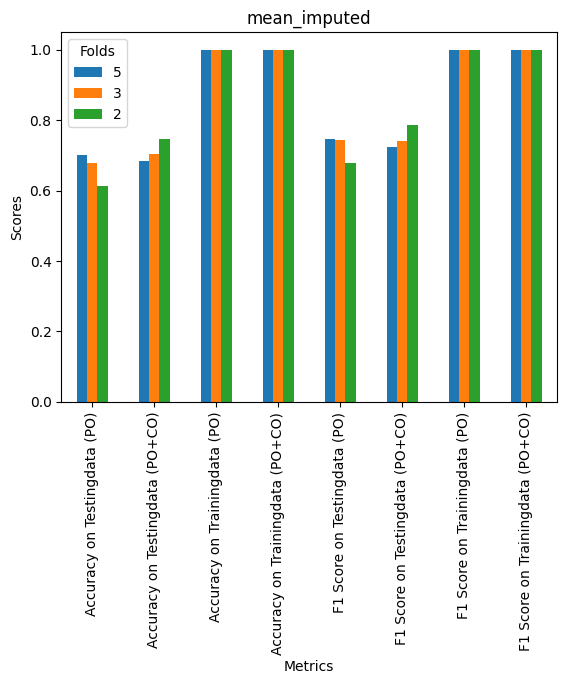

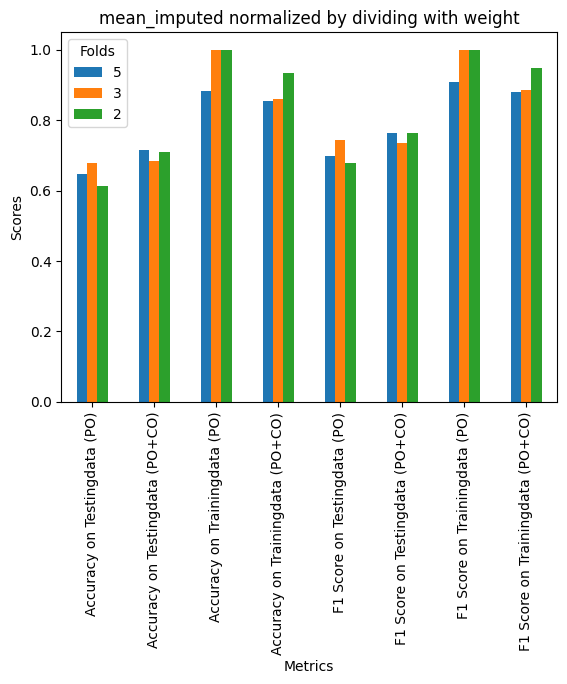

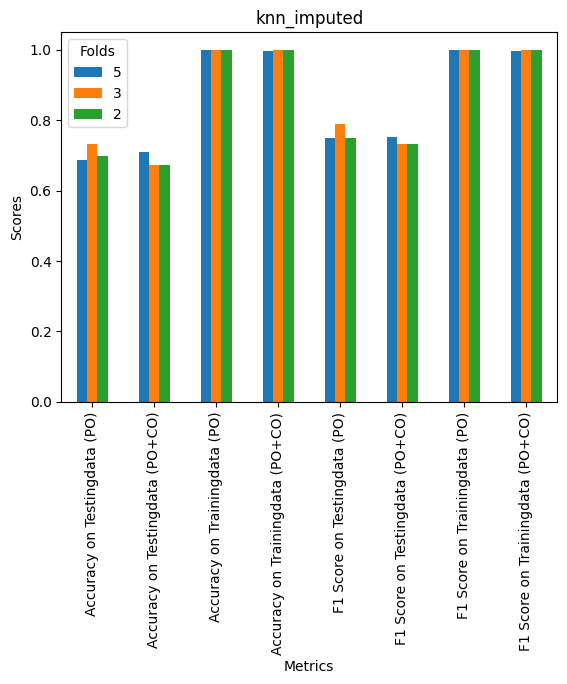

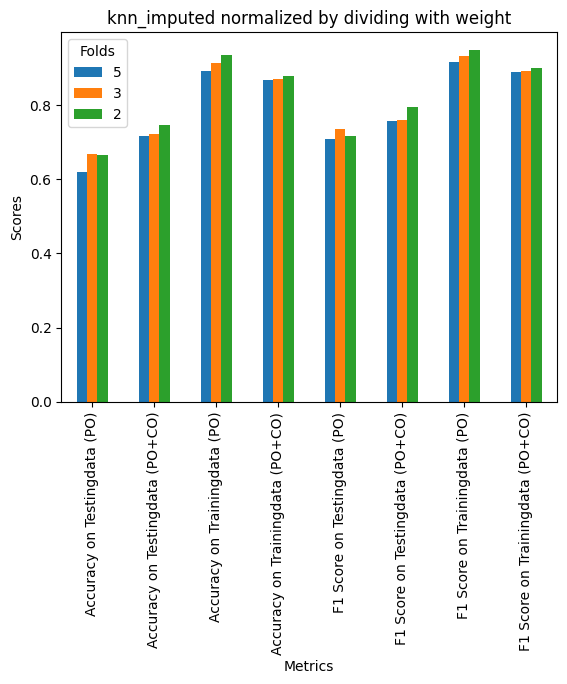

In [815]:
import matplotlib.pyplot as plt

dir = './results_as_csv/'
file_list = os.listdir(dir)

# Iterate over each CSV file
for file in file_list:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(dir + file)

    df = df.reindex(sorted(df.columns), axis=1)

    # Set "Folds" column as the index
    df.set_index('Folds', inplace=True)

    # Transpose the DataFrame
    df_transposed = df.T

    # Plot the transposed data as a bar chart
    df_transposed.plot(kind='bar')

    # Set the x-axis label
    plt.xlabel('Metrics')

    # Set the y-axis label
    plt.ylabel('Scores')

    # Set the plot title
    plt.title(file.replace('.csv', '').replace('_adjusted', ' normalized by dividing with weight'))

    # Show the legend with fold labels
    plt.legend(title='Folds')

    # Show the plot
    plt.show()


### Conclusion

Upon analyzing the results, it appears that there might be signs of overfitting in the model. Attempts to address this issue through cross-validation yielded limited improvements, as the accuracy and F1-scores remained consistently high on the training data but dropped significantly on the testing data, sometimes reaching as low as 0.6. Although the drop in performance is not always unfavorable, with some instances achieving scores of up to 0.8. This, combined with the limited size of the dataset makes interpretation in this regard harder so I am uncertain if it really is overfitting. However, it can be assumed that the amount of features resulting in my choice of using averages, medians, minimums, maximums and their ratio of all sensor data could have resulted in too many features which in return supports an overfitting assumption.

Furthermore, the visualization supports the previous assumption that the presence or absence of healthy patients within the dataset has minimal impact on the prediction accuracy. This leads to the conclusion that while the sensor values under the feet can, to some extent, be utilized for gender prediction, the severity of the Parkinson's disease does not hold significant predictive power in the classification. Therefore, it can be assumed that the answer to the research question, "Can we predict the gender of similarly sick patients based on the different burdening of the feet when walking (regarding sensor values under the feet)?" is negative.

In further research with more time, I would propose using different features on the sensor data to confirm or negate this conclusion. I'd also propose using different imputations or change the approach altogether s.t. no imputation on the disease metrics is needed at all. If that is possible, it might be helpful to select only one or two of the disease metrics, combined with less features of the sensor data to run more densed tests.